In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew 


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
SCRIPT_DIR = os.getcwd()
DATA_DIR = os.path.join(SCRIPT_DIR, '..', 'data')
print DATA_DIR

/Users/aravind/movie-ranking-recommendation-system/notebooks/../data


In [3]:
meta_data = pd.read_csv(DATA_DIR + '/movies_metadata.csv')
nsfw_data = pd.read_csv(DATA_DIR + '/nsfw_score.csv')
print meta_data.shape
print nsfw_data.shape

(45466, 24)
(45047, 2)


/Users/aravind/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Changing the column name
nsfw_data.columns = ['id', 'nsfw_score']

#Only using relevant data from the main csv
meta_data_subset = meta_data[['title', 'budget', 'id', 'original_language', 'popularity', 'revenue', 'vote_average', 'vote_count']]

#Converting both fields to the same data type
meta_data_subset['id'] = meta_data_subset['id'].astype(str)
nsfw_data['id'] = nsfw_data['id'].astype(str)

/Users/aravind/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
#merging the two dataframes
df = meta_data_subset.merge(nsfw_data, on='id', how='left')

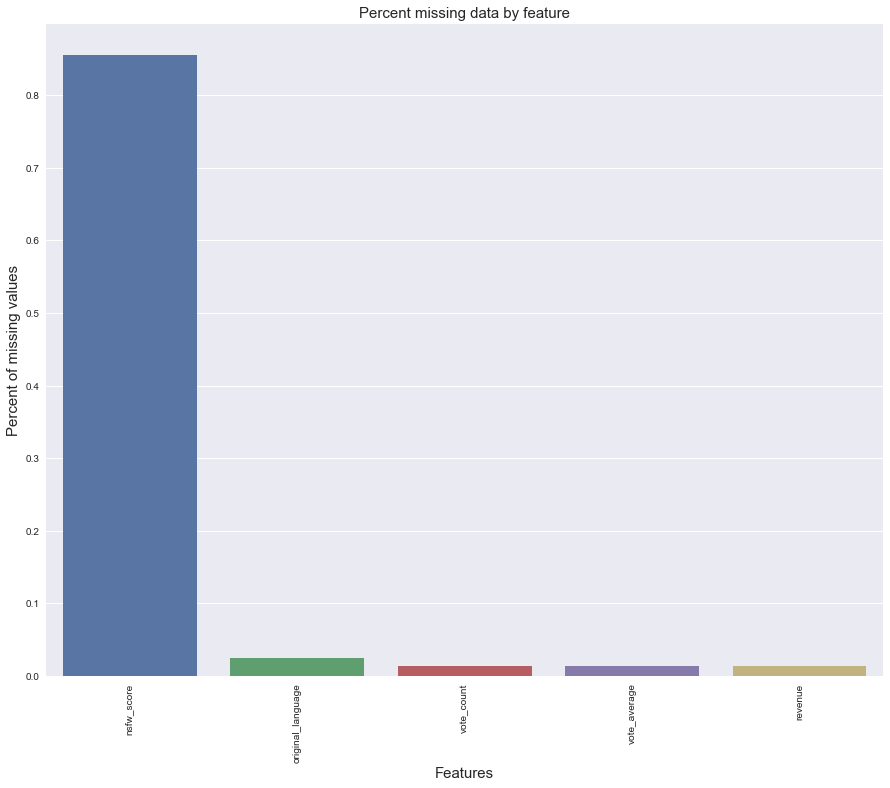

In [6]:
#Looking for missing values
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:5]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})

#plotting the missing data by percentages
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=df_na.index, y=df_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

We were unable to scrape the posters for 0.9% of the data, so we could not calculate the nsfw scores for those movies. This is insignifcant considering the size of our dataset. We can drop the missing values:

In [7]:
df.head()

,title,budget,id,original_language,popularity,revenue,vote_average,vote_count,nsfw_score
0,Toy Story,30000000,862,en,21.9469,373554033.0,7.7,5415.0,0.000582
1,Jumanji,65000000,8844,en,17.0155,262797249.0,6.9,2413.0,0.003873
2,Grumpier Old Men,0,15602,en,11.7129,0.0,6.5,92.0,0.010151
3,Waiting to Exhale,16000000,31357,en,3.85949,81452156.0,6.1,34.0,0.025879
4,Father of the Bride Part II,0,11862,en,8.38752,76578911.0,5.7,173.0,0.004546


In [8]:
#Dropping rows that have missing data
movie_data = df.dropna(axis=0)
print '{} rows dropped'.format(df.shape[0] - movie_data.shape[0])

400 rows dropped


In [9]:
#checking the data type of the columns
print movie_data.dtypes

title                 object
budget                object
id                    object
original_language     object
popularity            object
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object


In [10]:
#converting the data types as neccesary
movie_data.loc[:, 'budget'] = pd.to_numeric(movie_data['budget'])
movie_data.loc[:, 'original_language'] = movie_data.original_language.astype(str)
movie_data.loc[:,'popularity'] = pd.to_numeric(movie_data['popularity'])
print movie_data.dtypes

title                 object
budget                 int64
id                    object
original_language     object
popularity           float64
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object


/Users/aravind/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
#dropping rows with missing data
movie_df = movie_data.replace(0,'NaN')
movie_df = movie_df[(movie_df.revenue != 'NaN') & (movie_df.budget != 'NaN')]
print '{} rows dropped'.format(movie_data.shape[0] - movie_df.shape[0])
#replacing NaNs with 0 everywhere else
movie_df = movie_df.replace('NaN', 0)

39685 rows dropped


In [12]:
movie_df.dtypes

title                 object
budget                 int64
id                    object
original_language     object
popularity           float64
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object

In [13]:
#converting the data types again for some fucking reason
movie_df.loc[:, 'budget'] = pd.to_numeric(movie_df['budget'])
movie_df.loc[:, 'popularity'] = pd.to_numeric(movie_df['popularity'])
movie_df.loc[:, 'revenue'] = pd.to_numeric(movie_df['revenue'])
movie_df.loc[:, 'vote_average'] = pd.to_numeric(movie_df['vote_average'])
movie_df.loc[:, 'vote_count'] = pd.to_numeric(movie_df['vote_count'])
movie_df.loc[:, 'nsfw_score'] = pd.to_numeric(movie_df['nsfw_score'])
movie_df.dtypes

title                 object
budget                 int64
id                    object
original_language     object
popularity           float64
revenue              float64
vote_average         float64
vote_count           float64
nsfw_score           float64
dtype: object

In [14]:
#Adding profit column
movie_df['profit'] = movie_df['revenue'] >= movie_df['budget']
movie_df.loc[:, 'profit'] = movie_df['profit'].astype(int)

In [15]:
profitable = movie_df[movie_df['profit'] == 1]

In [16]:
nonprofitable = movie_df[movie_df['profit'] == 0]

#checking for skew
numeric_feats = movie_df.dtypes[(movie_df.dtypes != "object")].index
print 'The number of numeric features are {}'.format(numeric_feats.shape[0])
#Check the skew of all numerical features
skewed_feats = movie_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

#Using log transform on nsfw_score since it normalizes better than boxcox
movie_df.loc[:, 'nsfw_score'] = np.log(movie_df['nsfw_score'])

#Check the skew of all numerical features
skewed_feats = movie_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

#Using Box Cox Transform to fix skewed features
skewness = skewness[skewness['Skew'] > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    movie_df[feat] = boxcox1p(movie_df[feat], lam)

#Checking skew again
skewed_feats = movie_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

### Distribution

In [17]:
import seaborn as sns

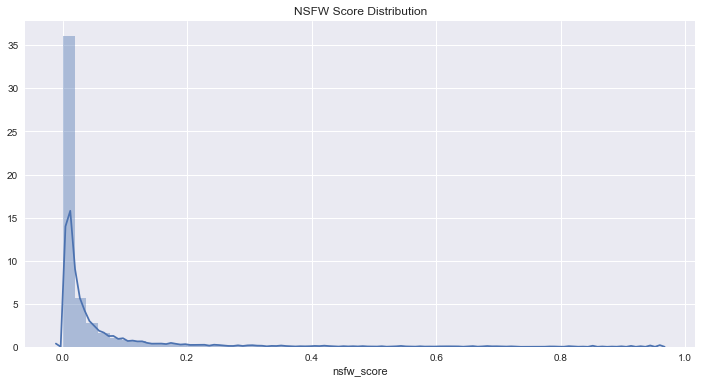

In [18]:
sns.distplot(movie_df['nsfw_score'])
plt.title('NSFW Score Distribution')

### Popularity Analysis

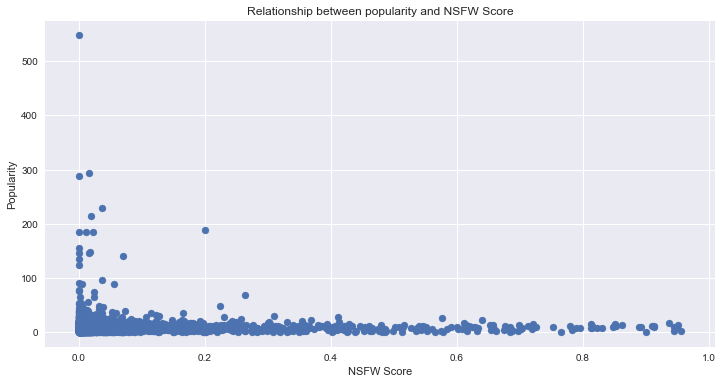

In [19]:
#Scatter plot after normalizing data
plt.scatter(movie_df['nsfw_score'], movie_df['popularity'])
plt.title('Relationship between popularity and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Popularity')
plt.show()

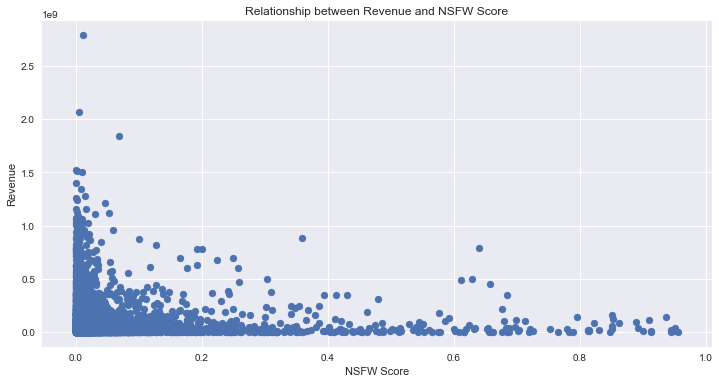

In [20]:
plt.scatter(movie_df['nsfw_score'], movie_df['revenue'])
plt.title('Relationship between Revenue and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Revenue')
plt.show()

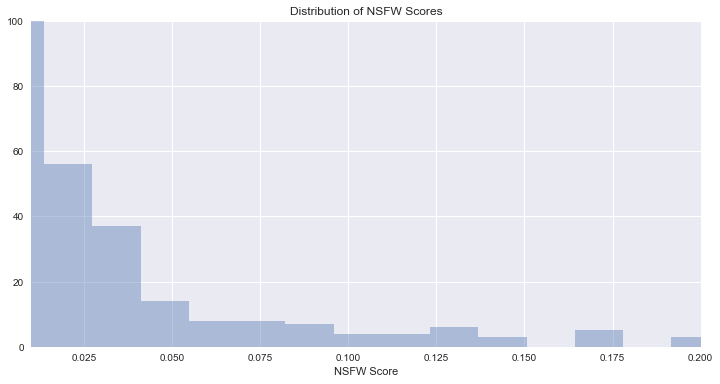

In [21]:
top10 = int(round(.10 * movie_df.shape[0]))
top10Movies = movie_df.sort_values(by=['revenue'],ascending=False).head(top10)
sns.distplot(top10Movies['nsfw_score'],kde=False)
plt.xlim(0.01,0.2)
plt.ylim(0,100)
plt.title('Distribution of NSFW Scores')
plt.xlabel('NSFW Score')
plt.show()

In [26]:
print top10
print bottom10

538
538


In [27]:
print top10Movies['nsfw_score'].mean()
print bottom10Movies['nsfw_score'].mean()

0.0345333174796
0.0618698016569


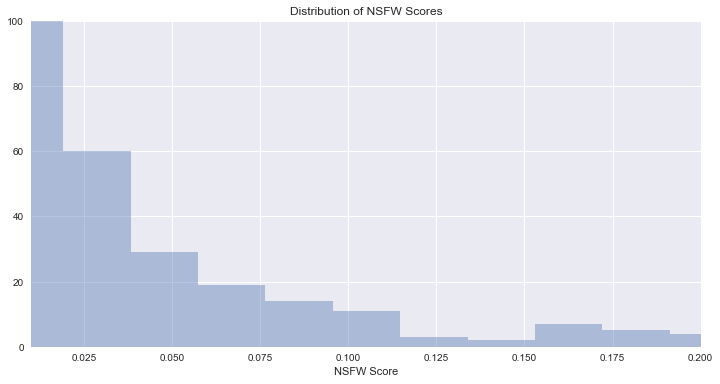

In [28]:
bottom10 = int(round(.10 * movie_df.shape[0]))
bottom10Movies = movie_df.sort_values(by=['revenue'],ascending=True).head(bottom10)
sns.distplot(bottom10Movies['nsfw_score'],kde=False)
plt.xlim(0.01,0.2)
plt.ylim(0,100)
plt.title('Distribution of NSFW Scores')
plt.xlabel('NSFW Score')
plt.show()

### Popularity Analysis

In [46]:
movie_df.head()

,title,budget,id,original_language,popularity,revenue,vote_average,vote_count,nsfw_score,profit
0,Toy Story,30000000,862,en,21.946943,373554033.0,7.7,5415.0,0.000582,1
1,Jumanji,65000000,8844,en,17.015539,262797249.0,6.9,2413.0,0.003873,1
3,Waiting to Exhale,16000000,31357,en,3.859495,81452156.0,6.1,34.0,0.025879,1
5,Heat,60000000,949,en,17.924927,187436818.0,7.7,1886.0,0.020958,1
8,Sudden Death,35000000,9091,en,5.231580,64350171.0,5.5,174.0,0.001103,1


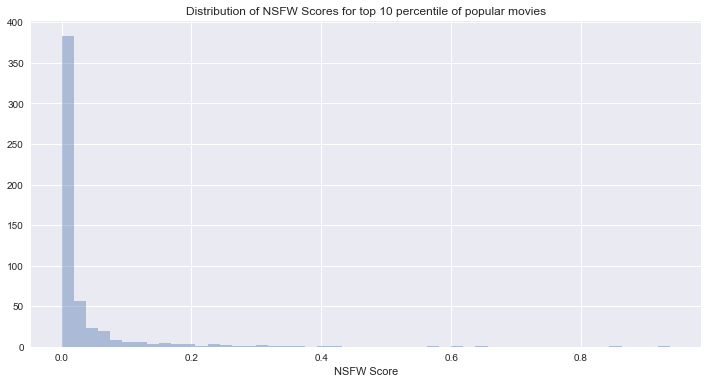

In [47]:
top10Popularity = movie_df.sort_values(by=['popularity'],ascending=False).head(top10)
sns.distplot(top10Popularity['nsfw_score'],kde=False)
plt.title('Distribution of NSFW Scores for top 10 percentile of popular movies')
plt.xlabel('NSFW Score')
plt.show()

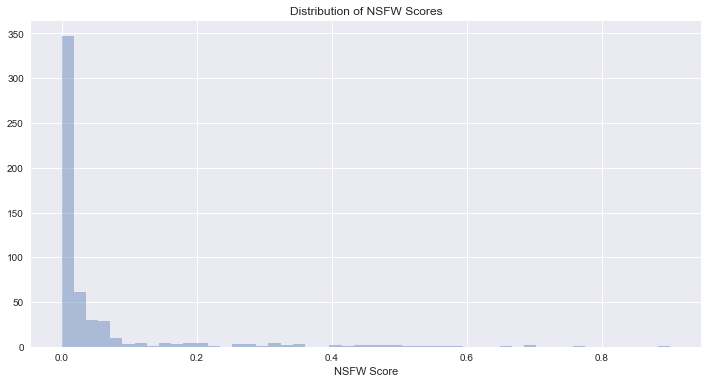

In [48]:
bottom10Popularity = movie_df.sort_values(by=['popularity'],ascending=True).head(bottom10)
sns.distplot(bottom10Popularity['nsfw_score'],kde=False)
plt.title('Distribution of NSFW Scores')
plt.xlabel('NSFW Score')
plt.show()

In [59]:
print 'The top 10% of popular movies have an average nsfw_score of {}'.format(top10Popularity['nsfw_score'].mean())
print 'The bottom 10% of popular movies have an average nsfw_score of {}'.format(bottom10Popularity['nsfw_score'].mean())

The top 10% of popular movies have an average nsfw_score of 0.034275148453
The bottom 10% of popular movies have an average nsfw_score of 0.0511102072898


### Profitable vs NonProfitable

In [30]:
profitable['nsfw_score'].mean()

0.04143211323484486

In [31]:
nonprofitable['nsfw_score'].mean()

0.040224983155931815

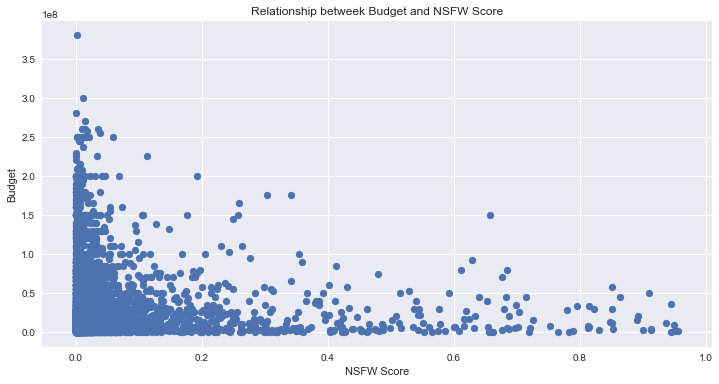

In [32]:
#Drop the budget 0s
plt.scatter(movie_df['nsfw_score'], movie_df['budget'])
plt.title('Relationship betweek Budget and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Budget')
plt.show()

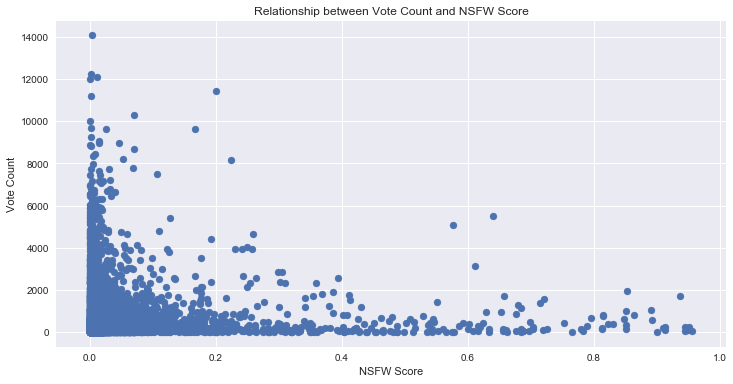

In [33]:
plt.scatter(movie_df['nsfw_score'], movie_df['vote_count'])
plt.title('Relationship between Vote Count and NSFW Score')
plt.xlabel('NSFW Score')
plt.ylabel('Vote Count')
plt.show()

In [34]:
from scipy.stats import pearsonr
#plt.scatter(movie_df['nsfw_score'], movie_df['profit'])
pearsonr(movie_df['nsfw_score'], movie_df['profit'])

(0.005158996498716371, 0.70516738908287824)

In [35]:
#Language Analysis
lang = set()
for index, row in movie_df.iterrows():
    lang.add(row['original_language'])
#print 'The languages present in the dataset are {}'.format(lang)


print 'Out of {} movies, there are {} english movies and {} non-english \
movies'.format(movie_df.shape[0], movie_df[movie_df.original_language == 'en'].shape[0], movie_df[movie_df.original_language != 'en'].shape[0])

Out of 5381 movies, there are 4799 english movies and 582 non-english movies


In [36]:
movie_en = movie_df[movie_df.original_language == 'en']
movie_foreign = movie_df[movie_df.original_language != 'en']

In [37]:
score1 = movie_en.nsfw_score.sum()/len(movie_en.nsfw_score)

In [38]:
score2 = movie_foreign.nsfw_score.sum()/len(movie_foreign.nsfw_score)

In [39]:
(score2-score1)/score1 * 100

8.219297796357269

In [40]:
np.var(movie_en.nsfw_score)

0.011254424776198148

In [41]:
movie_en_profit = movie_en[movie_en.profit == 1]
movie_en_loss = movie_en[movie_en.profit == 0]

In [56]:
print 'English profitable movies have an nsfw_score of {}'.format(movie_en_profit['nsfw_score'].mean())
print 'English loss-making movies have an nsfw_score of {}'.format(movie_en_loss['nsfw_score'].mean())

English profitable movies have an nsfw_score of 0.0412949610769
English loss-making movies have an nsfw_score of 0.039314372923


In [43]:
movie_foreign_profit = movie_foreign[movie_foreign.profit == 1]
movie_foreign_loss = movie_foreign[movie_foreign.profit == 0]

In [57]:
print 'Foreign profitable movies have an nsfw_score of {}'.format(movie_foreign_profit['nsfw_score'].mean())
print 'Foreign loss-making moives have an nsfw_score of {}'.format(movie_foreign_loss['nsfw_score'].mean())

Foreign profitable movies have an nsfw_score of 0.0426093939409
Foreign loss-making moives have an nsfw_score of 0.047088465603
